Compare output from cross_power diagnostic kernelto results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = "large"
mpl.rcParams["ytick.labelsize"] = "large"

import matplotlib.pyplot as plt
from scipy.signal import get_window, detrend

import timeit
import json

In [21]:
import sys
sys.path.append("/global/homes/r/rkube/repos/delta")

from analysis.kernels_spectral_cy import kernel_crosspower_cy, kernel_crosspower_v2

from analysis.task_fft import task_fft_scipy
from analysis.channels import channel, channel_pair, channel_range

In [5]:
# Run the fluctana code from RMCs examples/nersc/check_crossphase.py

In [6]:
def test_rmc():
    #import sys, os
    #sys.path.append(os.pardir)
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    # HOW TO RUN
    # ./python3 check_correlation.py 10186 [15.9,16] ECEI_L1303 ECEI_L1403

    shot = 18431 
    trange = [-0.1, -0.08]
    clist = [['ECEI_L1102'], ['ECEI_L0906']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # list data
    A.list_data()

    # do fft; full = 1 
    A.fftbins(nfft=512,window='hann',overlap=0.5,detrend=1,full=1)
    
    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.cross_power(done=0, dtwo=1)
    return(A)

In [7]:
tic = timeit.default_timer()
A = test_rmc()
toc = timeit.default_timer()

print(f"Fluctana takes {(toc - tic):6.4f}s")

Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1102, ref = 100%, siglevel = -0.0003 V
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0906, ref = 100%, siglevel = -0.0001 V
---- DATA SET # 0 for [-0.100000, -0.080000] s ----
[000:ECEI_L1102]
---- DATA SET # 1 for [-0.100000, -0.080000] s ----
[000:ECEI_L0906]
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 1 full 1
dnum 1 fftbins 37 with hann size 512 overlap 0.5 detrend 1 full 1
Fluctana takes 1.0369s


In [8]:
c1 = channel('L', 11, 2)
c2 = channel('L', 9, 6)

print("Channel 1: ", c1, ", idx = ", c1.idx())
print("Channel 2: ", c2, ", idx = ", c2.idx())
    
with np.load("../test_data/io_array_tr_s0001.npz") as df:
    # Load transformed data, as generated by datareader
    io_array_tr = df["io_array"]
    print("io_array_tr.shape = ", io_array_tr.shape)


print("io_array_tr.shape = ", io_array_tr.shape)

print(f"Channel idx for {c1}: {c1.idx()}, {c2}: {c2.idx()}")


Channel 1:  L1102 , idx =  81
Channel 2:  L0906 , idx =  69
io_array_tr.shape =  (192, 10000)
io_array_tr.shape =  (192, 10000)
Channel idx for L1102: 81, L0906: 69


In [11]:
with open("config_fft.json", "r") as df:
    config_fft = json.load(df)

In [12]:
config_fft

{'fft_params': {'nfft': 512,
  'window': 'hann',
  'overlap': 0.5,
  'detrend': 'constant',
  'full': True},
 'ECEI_cfg': {'TriggerTime': [-0.12, 61.2, 60],
  't_norm': [-0.119, -0.109],
  'SampleRate': 500,
  'TFcurrent': 23000.0,
  'Mode': 'O',
  'LoFreq': 81,
  'LensFocus': 80,
  'LensZoom': 340}}

In [13]:
config_fft["fft_params"]["fsample"] = config_fft["ECEI_cfg"]["SampleRate"] * 1e3
config_fft["fft_params"]["nfft"] = 512

win = get_window(config_fft["fft_params"]["window"], config_fft["fft_params"]["nfft"])
win_factor = (win**2).mean()
print(f"win_Factor = {win_factor}")


config_fft["fft_params"]["win_factor"] = win_factor

win_Factor = 0.375


In [14]:
my_fft = task_fft_scipy(10_000, config_fft["fft_params"], normalize=True, detrend=True)

In [15]:
fft_data = my_fft.do_fft_local(io_array_tr)

In [16]:
def my_cross_power(fft_data, ch_it, fft_params, info_dict):
     
    res = np.zeros([len(ch_it), fft_data.shape[1]], dtype=fft_data.dtype)
    for idx, ch_pair in enumerate(ch_it):
        res[idx, :] = (fft_data[ch_pair.ch1.idx(), :, :] * fft_data[ch_pair.ch2.idx(), :, :].conj()).mean(axis=1) / fft_params["win_factor"]
    
    return(np.abs(res).real, info_dict)

In [18]:
# Call the 
ch_it = [channel_pair(c1, c2)]
res, _ = my_cross_power(fft_data, ch_it, config_fft["fft_params"], None)
res = np.squeeze(res)

In [22]:
res_2 = kernel_crosspower_cy(np.ascontiguousarray(fft_data), ch_it, config_fft)
res_2 = np.squeeze(res_2, 0)

In [23]:
res_3 = kernel_crosspower_v2(np.ascontiguousarray(fft_data), ch_it, config_fft)
res_3 = np.squeeze(res_3, 0)

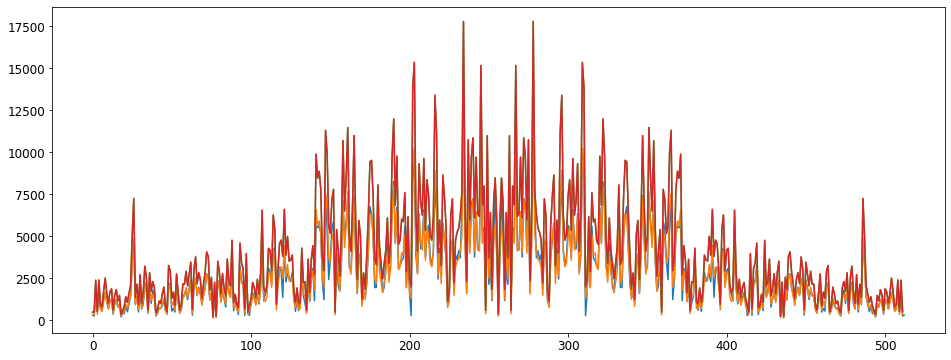

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0] * 4)
plt.plot(res)
plt.plot(res_2 * 4)
plt.plot(res_3 * 4)

In [51]:
np.linalg.norm(A.Dlist[1].val[0][1:] * 4 - res) / np.linalg.norm(res)

0.5979587152066455